**Deep Autoencoder**

Use to encoder and autoencoder images with different sizes.

Import libs

In [1]:
# Numpy and Matplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tensorflow and Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

import os


Directories

In [3]:
data_dir = './data'
results_dir = './results/'
metrics_dir = './metrics/'
models_dir = './models/'
resized_dir = './resized_dir/'

Class DeepAutoencoder

In [32]:
class DeepAutoencoder(object):

    def __init__(self, input_dim, encoded_dim):
        
        input_img = Input(shape=(input_dim,))

        encoded = Dense(16 * encoded_dim, activation='relu')(input_img)
        encoded = Dense(8 * encoded_dim, activation='relu')(encoded)
        encoded = Dense(4 * encoded_dim, activation='relu')(encoded)
        encoded = Dense(2 * encoded_dim, activation='relu')(encoded)
        encoded = Dense(encoded_dim, activation='relu')(encoded)
        
#         Dropout(0.2)

        decoded = Dense(2 * encoded_dim, activation='relu')(encoded)
        decoded = Dense(4 * encoded_dim, activation='relu')(decoded)
        decoded = Dense(8 * encoded_dim, activation='relu')(decoded)
        decoded = Dense(16 * encoded_dim, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)
         
        self.autoencoder = Model(input_img, decoded)
        self.encoder = Model(input_img, encoded)
        
        self.autoencoder.summary()
        self.encoder.summary()

        self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, input_train, input_test, batch_size, epochs):    
        self.autoencoder.fit(input_train, input_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(input_test, input_test))
    
    def get_encoded_image(self, image):
        encoded_img = self.encoder.predict(image)
        return encoded_img
    
    def get_decoded_image(self, encoded_img):
        decoded_img = self.autoencoder.predict(encoded_img)
        return decoded_img

    def get_evaluate_model(self, train, test):
        autoencoder_evaluate = self.autoencoder.evaluate(train, test)
        return autoencoder_evaluate

    def get_history_model(self):
        autoencoder_history = self.autoencoder.history
        return autoencoder_history
    
    def save_model(self, name):
        name = name[:-4]
        self.autoencoder.save(models_dir + 'model_autoencoder_' + name + '.h5')
        self.encoder.save(models_dir + 'model_encoder_' + name + '.h5')

Utils

In [5]:
def plot_metrics_subplot(history, name):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot training & validation accuracy values
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.legend(['Train', 'Test'], loc='upper right')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.legend(['Train', 'Test'], loc='upper right')

    fig.savefig(metrics_dir + 'subplot_' + name)


def plot_metrics(history, name):    
    fig = plt.figure()
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    fig.savefig(metrics_dir + 'acc_' + name)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    fig.savefig(metrics_dir + 'loss_' + name)

def plot_all(images):
    fig = plt.figure(figsize=(32, 32))
    number_rows = int(len(images)/3) + 1
    
    for index in range(len(images)):
        a = fig.add_subplot(number_rows, 3, index+1)
        plt.imshow(images[index])
        plt.title(f'{index}:{images[index].shape}')
        a.axis('off')
    
    fig.savefig(metrics_dir + 'compare_images.png')
    plt.show()

def plot_evaluate(model, name):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_title('Loss: %.2f%%' % (model[0]*100))
    ax1.plot([0, 100], [0, model[0]*100])
    fig.savefig(metrics_dir + 'loss_' + name)

    ax2.set_title('Accuracy: %.2f%%' % (model[1]*100))
    ax2.plot([0, 100], [0, model[1]*100])
    fig.savefig(metrics_dir + 'accuracy_' + name)

def save_image(name, image):        
    mpimg.imsave(results_dir + name, image)

def resized_images():
    file = os.listdir(DIR_ORIGINAL_IMAGES_DATA)
    size = sum(1 for img in file)

    train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        save_to_dir=resized_dir,
        batch_size=64,
        class_mode='input',
        color_mode='rgba')

    index = 0
    for batch in train_generator:
        index += 1
        if index <= size:
            break


Class main()

In [33]:
def main():
    images = []
    historic = []
    
    for img in os.listdir(data_dir):
        try: 
            # Normalização das imagens     
            img_train = mpimg.imread((os.path.join(data_dir, img)))
            max_train_value = float(img_train.max())
            train = img_train.astype('float32') / max_train_value
            train = train.reshape((len(train), np.prod(train.shape[1:])))

            img_test = mpimg.imread((os.path.join(data_dir, img)))
            max_test_value = float(img_test.max())
            test = img_test.astype('float32') / max_test_value
            test = test.reshape((len(test), np.prod(test.shape[1:])))

            # Envio da imagem para a classe DeepAutoencoder
            autoencoder = DeepAutoencoder(train.shape[1], 64)
            autoencoder.train(train, test, 64, 10)
            
            encoded_img = autoencoder.get_encoded_image(test)
            decoded_img = autoencoder.get_decoded_image(test)

            autoencoder_history = autoencoder.get_history_model()
            autoencoder_evaluate = autoencoder.get_evaluate_model(train, test)
            
            autoencoder.save_model(img)
            
            plot_evaluate(autoencoder_evaluate, 'autoencoder_evaluate_' + img)

            # Dimensões da imagem original
            to_reshape = img_train.shape

            # Redimensionamento das imagens obtidas
            x_original_result = test.reshape(to_reshape[0], to_reshape[1], to_reshape[2])
            decoded_img_result = decoded_img.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      

            images.append(x_original_result)
            images.append(encoded_img)
            images.append(decoded_img_result)

            plot_metrics_subplot(autoencoder_history, 'autoencoder_history_' + img)
            
            plot_metrics(autoencoder_history, 'autoencoder_history_' + img)
            
            save_image('original_' + img, x_original_result)
            save_image('encoded_img_' + img, encoded_img)
            save_image('decoded_img_' + img, decoded_img_result)
        except Exception as e:
            print(e)
            pass
    
    return images

Iteration about images of Satellite

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
dense_200 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_201 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_202 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_203 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_204 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_205 (Dense)            (None, 128)               8320      
__________

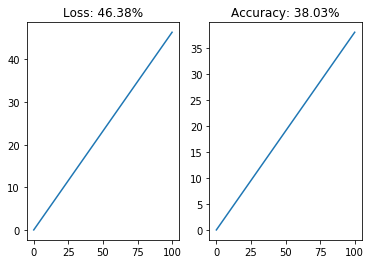

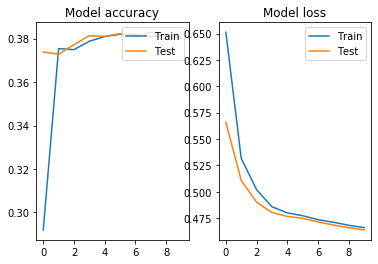

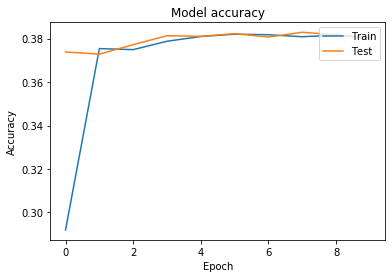

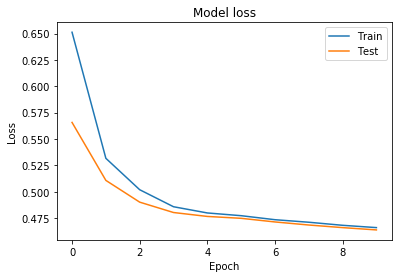

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
dense_210 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_211 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_212 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_213 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_214 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_215 (Dense)            (None, 128)               8320      
__________

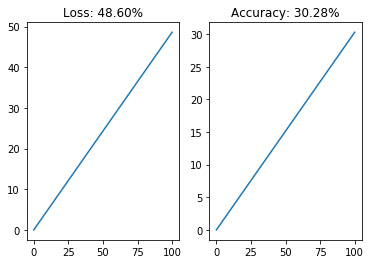

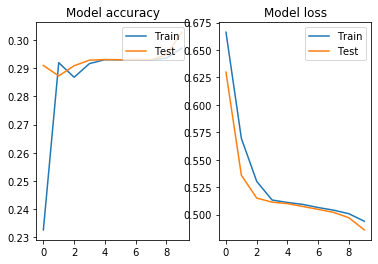

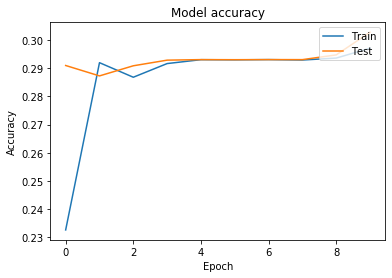

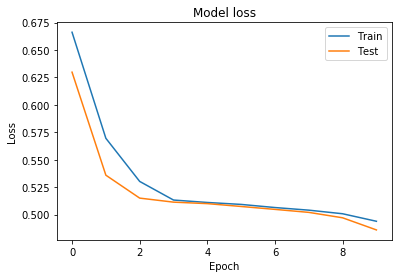

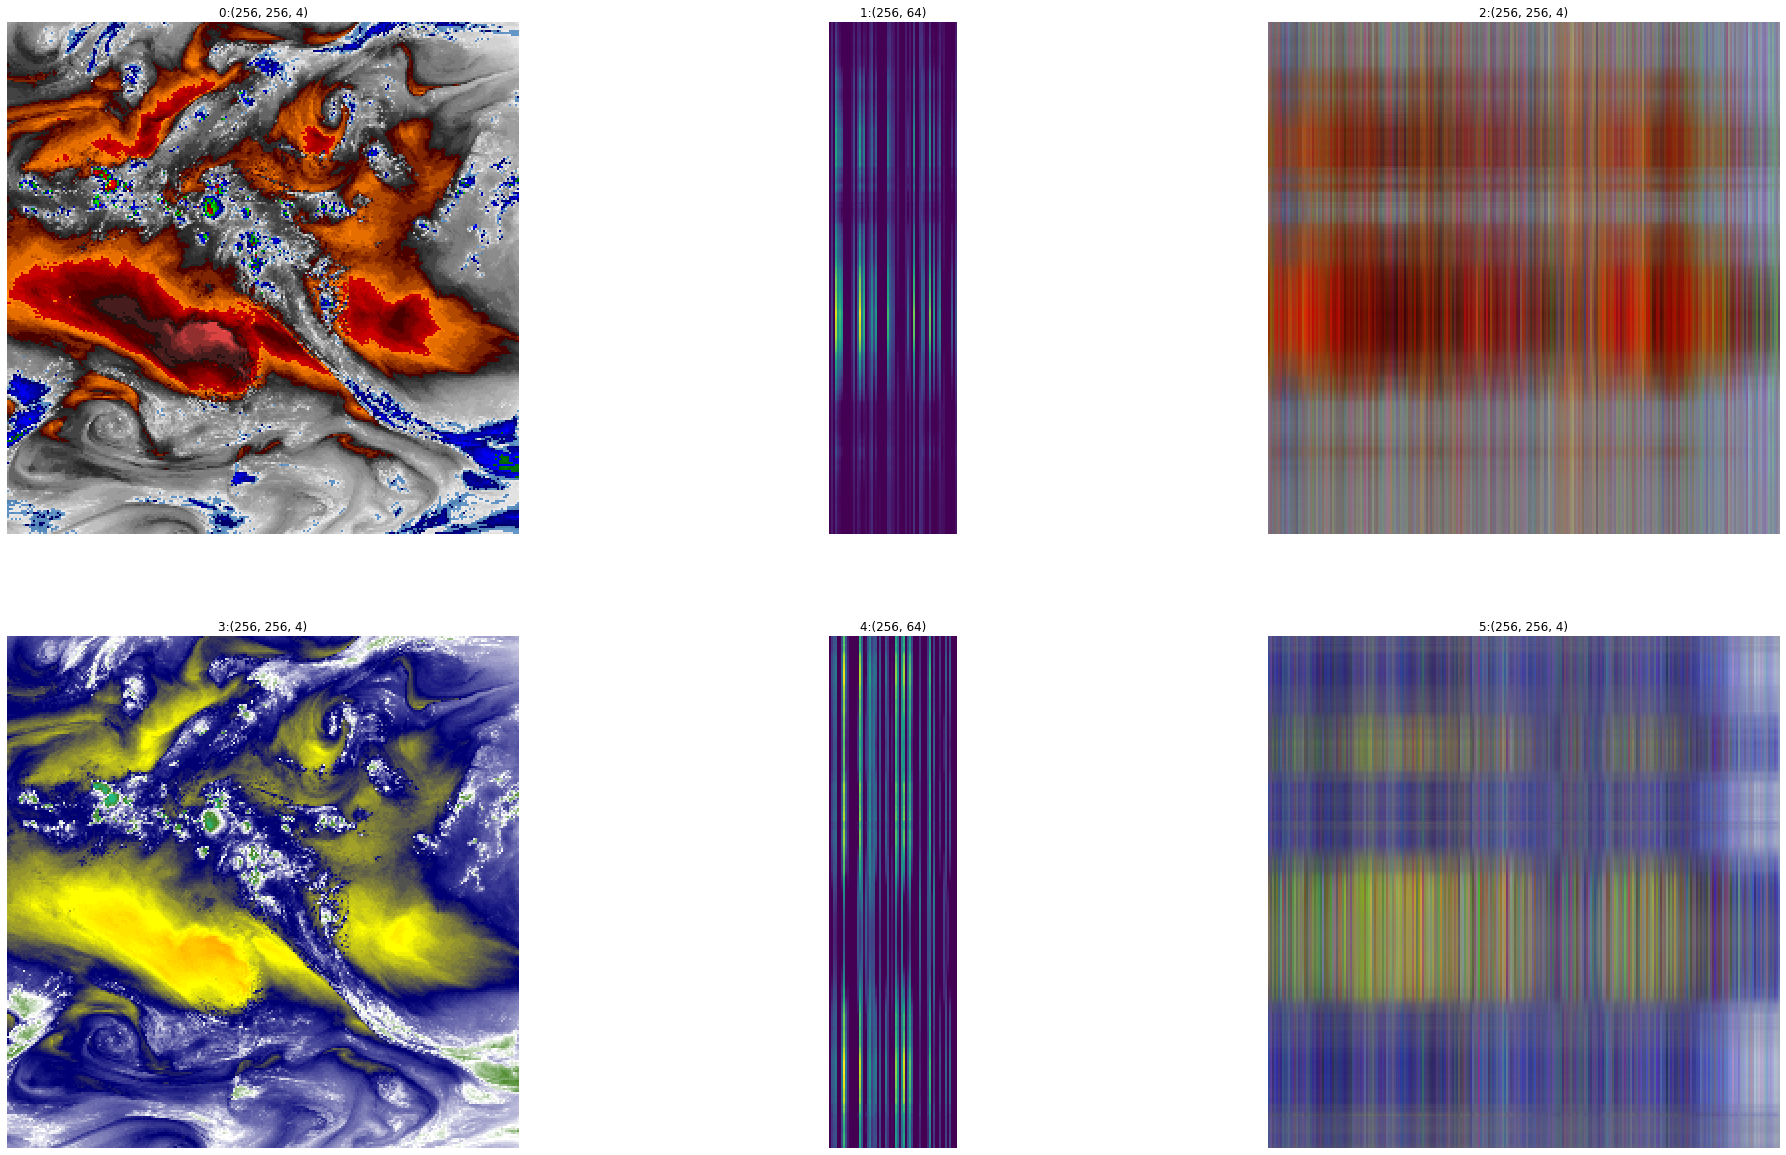

In [34]:
images = main()
plot_all(images)

Load model

In [10]:
model_autoencoder_save = load_model('./models/model_autoencoder__3_7880292.h5')
model_encoder_save = load_model('./models/model_encoder__3_7880292.h5')

model_autoencoder_save.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_encoder_save.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

img_test = mpimg.imread('./data/_3_7880292.png')
max_test_value = float(img_test.max())
test_autoencoder = img_test.astype('float32') / max_test_value
test_autoencoder = test_autoencoder.reshape((len(test_autoencoder), np.prod(test_autoencoder.shape[1:])))

to_reshape = img_test.shape

test_encoder = model_encoder_save.predict(test_autoencoder)
test_autoencoder = model_autoencoder_save.predict(test_autoencoder)

test_autoencoder_result = test_autoencoder.reshape(to_reshape[0], to_reshape[1], to_reshape[2])      

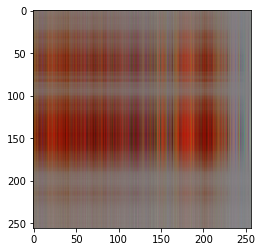

In [11]:
plt.imshow(test_autoencoder_result)


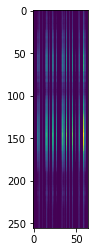

In [12]:
plt.imshow(test_encoder)